In [1]:
import broadbean as bb
from sequence_builder import SequenceBuilder
from broadbean.plotting import plotter


In [2]:
bla = SequenceBuilder('hip')

In [3]:
bla.cycle_time = 4e-6
bla.pulse_time = 0.6e-6
bla.readout_time = 2.5e-6
bla.marker_offset = 0e-9
npts = 5
start = 4.5e3
stop = 5.0e6

In [4]:
bla.SR.set(1.5e9)
bla.MultiQ_SSB_Spec_NoOverlap(start, stop, npts)

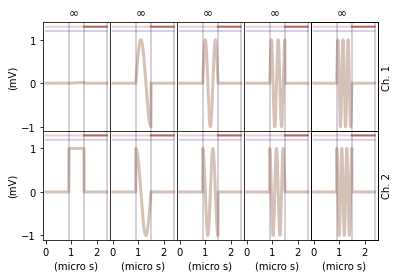

In [5]:
plotter(bla.seq.get())

In [6]:
bla.SR.set(1.5e9)

In [7]:
dis = bla.seq.snapshot()

In [8]:
snapseq = bb.Sequence().sequence_from_description(dis)


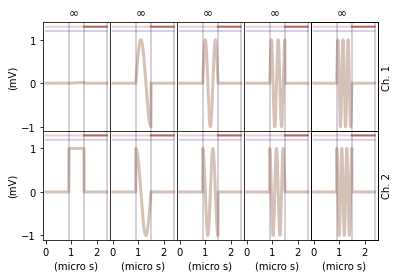

In [10]:
plotter(snapseq)